In [2]:
import numpy as np
import scanpy as sc
import os
import pandas as pd
import scanpy.external as sce
import anndata as ad
import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt

scv.settings.verbosity = 3 
scv.settings.presenter_view = True  

- The analyis is based on enterocytes ad colonocytes' expression alone  
- For the human -Based of adult alone - since there aren't healthy colon pediatric samples 
- shuman - Human enterocytes, lhuman - Human colonocytes. Same for mouse - smouse,lmouse
- MT genes are not included in the analysis

In [3]:
mtgenes = ['COX1','COX2', 'COX3', 'ND1', 'ND2', 'ND3', 'ND4', 'ND5', 'ND6', 'ND4L', 'ATP6', 'ATP8', 'CYTB']

# SI vs colon DE 

In [4]:
import random
def down_sampling(adata1,adata2):
    min_cells = min(adata1.shape[0],adata2.shape[0])
    data1 = list(adata1.obs_names)
    data2 = list(adata2.obs_names)
    random.seed(1)
    barcodes1 =random.sample(data1, k=min_cells)
    barcodes2 =random.sample(data2, k=min_cells)

    return adata1[adata1.obs.index.isin(barcodes1)],adata2[adata2.obs.index.isin(barcodes2)]

In [6]:
orthology = pd.read_csv("mouse_human_bat_orthologs.csv",index_col=0)

## Human DE 

In [13]:
human = sc.read(r"Full_obj_raw_counts_nosoupx.h5ad")
human.obs.rename(columns={'pct_counts_mt':'pct_counts_MT'},inplace=True)
human.obs.rename(columns={'sample name':'Sample'},inplace=True)
human.obs.rename(columns={'Integrated_05':'cell_type'},inplace=True)

human_eggnog_dict =dict(zip(orthology['human gene id'],orthology.eggnog_name))
human =  human[:, human.var["gene_ids"].isin(human_eggnog_dict.keys())]
human.var['eggnog_name'] = human.var.gene_ids.map(human_eggnog_dict).astype('category') 
human.var.set_index('eggnog_name',inplace=True)    

shuman = human[(human.obs.Gender=='M')&((human.obs.Diagnosis.isin(['Healthy adult']))&(human.obs.Region=='SmallInt')&(human.obs['Region code']!='DUO'))]
shuman = shuman[shuman.obs.cell_type=='Enterocyte']
chuman = human[(human.obs.Gender=='M')&((human.obs.Diagnosis.isin(['Healthy adult']))&(human.obs.Region=='LargeInt'))]
chuman = chuman[chuman.obs.cell_type=='Colonocyte']

#dismiss samples with less than 10 cells
less_than_10_cells = list(shuman.obs['Sample'].value_counts()[shuman.obs['Sample'].value_counts()<10].index)
shuman = shuman[~shuman.obs['Sample'].isin(less_than_10_cells)]
shuman = shuman[~shuman.obs['Sample'].isin(less_than_10_cells)]

less_than_10_cells = list(chuman.obs['Sample'].value_counts()[chuman.obs['Sample'].value_counts()<10].index)
chuman = chuman[~chuman.obs['Sample'].isin(less_than_10_cells)]
chuman = chuman[~chuman.obs['Sample'].isin(less_than_10_cells)]

del(human)

In [14]:
shuman,chuman = down_sampling(shuman,chuman) # Downsampling

In [15]:
hdata = shuman.concatenate(chuman, batch_categories=['Small_int', 'colon'],index_unique=('-'))
del(shuman,chuman)

In [16]:
def processing_batch(adata,neighbors = 15,key='Sample',reso=1):
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.logging.print_memory_usage()
    sc.pp.neighbors(adata, n_neighbors=neighbors)
    import bbknn
    bbknn.bbknn(adata, batch_key=key, neighbors_within_batch=2, metric='euclidean', n_pcs=30,trim=None)
    sc.tl.umap(adata)

Memory usage: current 1.53 GB, difference +1.53 GB


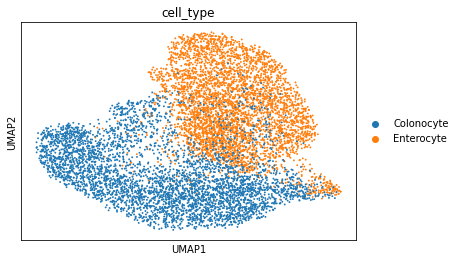

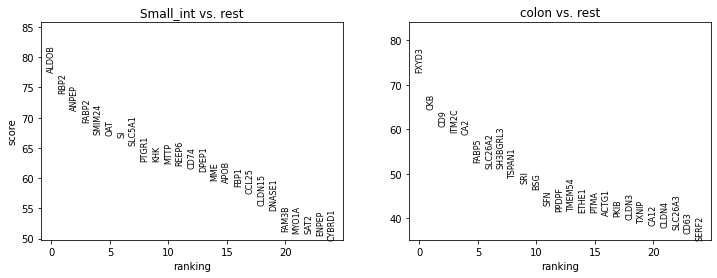

In [17]:
sc.pp.normalize_total(hdata)
sc.pp.log1p(hdata)
sc.pp.highly_variable_genes(hdata, min_mean=0.0125, max_mean=3, min_disp=0.5)
hdata.raw = hdata
sc.pp.regress_out(hdata, ['total_counts','pct_counts_MT'])
processing_batch(hdata,key='Sample')
sc.pl.umap(hdata, color=['cell_type'])

sc.tl.rank_genes_groups(hdata, 'batch', method='wilcoxon')
sc.pl.rank_genes_groups(hdata, n_genes=25, sharey=False)

In [18]:
result = hdata.uns['rank_genes_groups']
groups = result['names'].dtype.names
hdata_de = pd.DataFrame(
{group + '_' + key[:]: result[key][group]
for group in groups for key in ['names','logfoldchanges','pvals','pvals_adj']})

hsmall_de = hdata_de[['Small_int_names','Small_int_logfoldchanges','Small_int_pvals','Small_int_pvals_adj']].copy()
hsmall_de.set_index('Small_int_names',inplace=True)
hsmall_de=hsmall_de[(hsmall_de.Small_int_pvals_adj<0.01)&(hsmall_de.Small_int_logfoldchanges>0)]
hsmall_de.sort_values(by='Small_int_pvals_adj',inplace=True)
hsmall_de = hsmall_de[~hsmall_de.index.isin(mtgenes)]

hcolon_de = hdata_de[['colon_names','colon_logfoldchanges','colon_pvals','colon_pvals_adj']].copy()
hcolon_de.set_index('colon_names',inplace=True)
hcolon_de=hcolon_de[(hcolon_de.colon_pvals_adj<0.01)&(hcolon_de.colon_logfoldchanges>0)]
hcolon_de.sort_values(by='colon_pvals_adj',inplace=True)
hcolon_de = hcolon_de[~hcolon_de.index.isin(mtgenes)]

del(hdata_de)

## Mouse DE

In [24]:
mouse_eggnog_dict =dict(zip(orthology['mouse_gene_id'],orthology.eggnog_name))

smouse = sc.read(r"C:\Users\TzachiHNB5\Documents\Project_barrier_immune\scanpy\Scanpy_mice\mouse_all_small\final_files\final_010123\with_extra_mouse_from_large\mouse_small_intestine_raw.h5ad")
smouse = smouse[smouse.obs.Sample!='mouse4_b'] # Removing replicate sample of mouse 4
smouse = smouse[smouse.obs.cell_type=='Enterocyte']
smouse =  smouse[:, smouse.var["Ensembl"].isin(mouse_eggnog_dict.keys())]
smouse.var['eggnog_name'] = smouse.var.Ensembl.map(mouse_eggnog_dict).astype('category') 
smouse.var.set_index('eggnog_name',inplace=True)    

cmouse = sc.read(r"C:\Users\TzachiHNB5\Documents\Project_barrier_immune\scanpy\Scanpy_mice\mouse_all_large\final_files\mouse_large_intestine_raw.h5ad")
cmouse = cmouse[cmouse.obs.cell_type=='Colonocyte']
cmouse =  cmouse[:, cmouse.var["Ensembl"].isin(mouse_eggnog_dict.keys())]
cmouse.var['eggnog_name'] = cmouse.var.Ensembl.map(mouse_eggnog_dict).astype('category') 
cmouse.var.set_index('eggnog_name',inplace=True)    

In [25]:
smouse,cmouse = down_sampling(smouse,cmouse) # Downsampling

In [26]:
mdata = smouse.concatenate(cmouse, batch_categories=['Small_int', 'colon'],index_unique=('-'))
del(smouse,cmouse)

Memory usage: current 2.53 GB, difference +1.00 GB


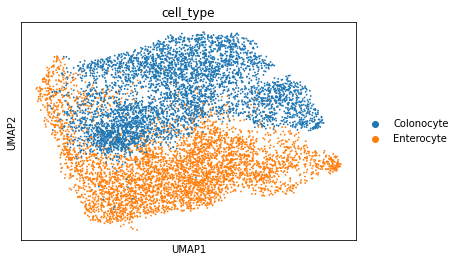

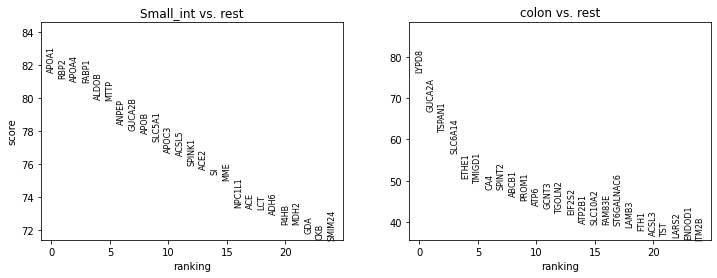

In [27]:
sc.pp.normalize_total(mdata)
sc.pp.log1p(mdata)
sc.pp.highly_variable_genes(mdata, min_mean=0.0125, max_mean=3, min_disp=0.5)
mdata.raw = mdata
sc.pp.regress_out(mdata, ['total_counts','pct_counts_MT'])
processing_batch(mdata,key='Sample')
sc.pl.umap(mdata, color=['cell_type'])

sc.tl.rank_genes_groups(mdata, 'batch', method='wilcoxon')
sc.pl.rank_genes_groups(mdata, n_genes=25, sharey=False)

In [28]:
result = mdata.uns['rank_genes_groups']
groups = result['names'].dtype.names
mdata_de = pd.DataFrame(
{group + '_' + key[:]: result[key][group]
for group in groups for key in ['names','logfoldchanges','pvals','pvals_adj']})

msmall_de = mdata_de[['Small_int_names','Small_int_logfoldchanges','Small_int_pvals','Small_int_pvals_adj']].copy()
msmall_de.set_index('Small_int_names',inplace=True)
msmall_de=msmall_de[(msmall_de.Small_int_pvals_adj<0.01)&(msmall_de.Small_int_logfoldchanges>0)]
msmall_de.sort_values(by='Small_int_pvals_adj',inplace=True)
msmall_de = msmall_de[~msmall_de.index.isin(mtgenes)]

mcolon_de = mdata_de[['colon_names','colon_logfoldchanges','colon_pvals','colon_pvals_adj']].copy()
mcolon_de.set_index('colon_names',inplace=True)
mcolon_de=mcolon_de[(mcolon_de.colon_pvals_adj<0.01)&(mcolon_de.colon_logfoldchanges>0)]
mcolon_de.sort_values(by='colon_pvals_adj',inplace=True)
mcolon_de = mcolon_de[~mcolon_de.index.isin(mtgenes)]

del(mdata_de)

## Mutual human-mouse SI/colon genes

In [29]:
small_genes= pd.merge(hsmall_de,msmall_de , left_index=True, right_index=True,suffixes=('_human', '_mouse'),)
colon_genes= pd.merge(hcolon_de,mcolon_de , left_index=True, right_index=True,suffixes=('_human', '_mouse'),)

In [31]:
# Max Q value is detemined for each gene in order to sort genes so that the ones that are most significant in both mouse and human will appear first
small_genes['max_qval'] = float()  
for i in small_genes.index:
    small_genes.at[i,'max_qval'] = max(small_genes.at[i,'Small_int_pvals_adj_human'],(small_genes.at[i,'Small_int_pvals_adj_mouse']))
    colon_genes['max_qval'] = float()  
for i in colon_genes.index:
    colon_genes.at[i,'max_qval'] = max(colon_genes.at[i,'colon_pvals_adj_human'],(colon_genes.at[i,'colon_pvals_adj_mouse']))

In [32]:
small_genes.sort_values(by='max_qval',inplace=True)
colon_genes.sort_values(by='max_qval',inplace=True)

In [33]:
small_genes.to_csv('small_intestine_genes.csv')
colon_genes.to_csv('colon_intestine_genes.csv')

# Multi- speices anndata object

In [34]:
#For multiple samples 
def down_sampling(adatas):
    min_cells = min([adata.shape[0] for adata in adatas])
    datas=[]
    for adata in adatas:
        datas.append(list(adata.obs_names))

    random.seed(1)
    barcodes = []
    for data in datas:
        barcodes.append(random.sample(data, k=min_cells))
    return [adatas[i][adatas[i].obs.index.isin(barcodes[i])] for i in range(0,len(adatas))]

In [35]:
human = sc.read(r"C:\Users\TzachiHNB5\Documents\Project_barrier_immune\references\gut\data\Full_obj_raw_counts_nosoupx.h5ad")
human.obs.rename(columns={'pct_counts_mt':'pct_counts_MT'},inplace=True)
human.obs.rename(columns={'sample name':'Sample'},inplace=True)
human.obs.rename(columns={'Integrated_05':'cell_type'},inplace=True)

human =  human[:, human.var["gene_ids"].isin(human_eggnog_dict.keys())]
human.var['eggnog_name'] = human.var.gene_ids.map(human_eggnog_dict).astype('category') 
human.var.set_index('eggnog_name',inplace=True)    

shuman = human[(human.obs.Gender=='M')&((human.obs.Diagnosis.isin(['Healthy adult']))&(human.obs.Region=='SmallInt')&(human.obs['Region code']!='DUO'))]
shuman = shuman[shuman.obs.cell_type=='Enterocyte']
chuman = human[(human.obs.Gender=='M')&((human.obs.Diagnosis.isin(['Healthy adult']))&(human.obs.Region=='LargeInt'))]
chuman = chuman[chuman.obs.cell_type=='Colonocyte']

#dismiss samples with less than 10 cells
less_than_10_cells = list(shuman.obs['Sample'].value_counts()[shuman.obs['Sample'].value_counts()<10].index)
shuman = shuman[~shuman.obs['Sample'].isin(less_than_10_cells)]
shuman = shuman[~shuman.obs['Sample'].isin(less_than_10_cells)]

less_than_10_cells = list(chuman.obs['Sample'].value_counts()[chuman.obs['Sample'].value_counts()<10].index)
chuman = chuman[~chuman.obs['Sample'].isin(less_than_10_cells)]
chuman = chuman[~chuman.obs['Sample'].isin(less_than_10_cells)]

del(human)

In [36]:
smouse = sc.read(r"C:\Users\TzachiHNB5\Documents\Project_barrier_immune\scanpy\Scanpy_mice\mouse_all_small\final_files\final_010123\with_extra_mouse_from_large\mouse_small_intestine_raw.h5ad")
smouse = smouse[smouse.obs.Sample!='mouse4_b'] # Removing replicate sample of mouse 4
smouse = smouse[smouse.obs.cell_type=='Enterocyte']
smouse =  smouse[:, smouse.var["Ensembl"].isin(mouse_eggnog_dict.keys())]
smouse.var['eggnog_name'] = smouse.var.Ensembl.map(mouse_eggnog_dict).astype('category') 
smouse.var.set_index('eggnog_name',inplace=True)    

cmouse = sc.read(r"C:\Users\TzachiHNB5\Documents\Project_barrier_immune\scanpy\Scanpy_mice\mouse_all_large\final_files\mouse_large_intestine_raw.h5ad")
cmouse = cmouse[cmouse.obs.cell_type=='Colonocyte']
cmouse =  cmouse[:, cmouse.var["Ensembl"].isin(mouse_eggnog_dict.keys())]
cmouse.var['eggnog_name'] = cmouse.var.Ensembl.map(mouse_eggnog_dict).astype('category') 
cmouse.var.set_index('eggnog_name',inplace=True)    

In [37]:
bat_eggnog_dict =dict(zip(orthology['bat gene name'],orthology.eggnog_name)) 
bat = sc.read(r"C:\Users\TzachiHNB5\Documents\Project_barrier_immune\scanpy\scanpy_bat1k\gut\final_files\final_files\gut_raw_bat1k.h5ad")
bat = bat[bat.obs.cell_type=='Enterocyte']
bat =  bat[:, bat.var["original_name"].isin(bat_eggnog_dict.keys())]
bat.var['eggnog_name'] = bat.var.original_name.map(bat_eggnog_dict).astype('category') 
bat.var.set_index('eggnog_name',inplace=True)    

In [38]:
bat,smouse,cmouse,shuman,chuman = down_sampling([bat,smouse,cmouse,shuman,chuman])

In [39]:
adata = shuman.concatenate([chuman,smouse,cmouse,bat], batch_categories=['Human S', 'Human L','Mouse S', 'Mouse L','Bat'],index_unique=('-'),)
del(bat,smouse,cmouse,shuman,chuman)

In [40]:
adata.uns['batch_colors'] = ['#D3D3D3', '#484848','#D3D3D3','#484848','#989898']

In [41]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.regress_out(adata, ['total_counts','pct_counts_MT'])
sc.pp.scale(adata, max_value=10)

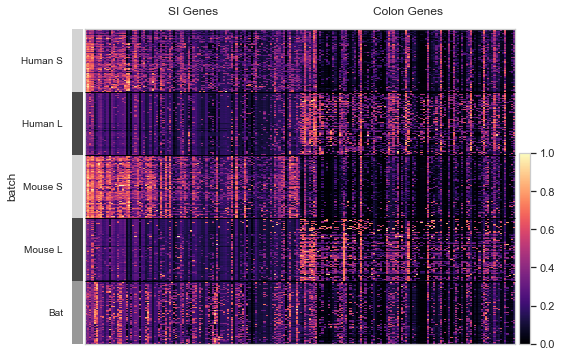

In [58]:
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

i=100    
small_colon_genes = {'SI Genes': list(small_genes.index[0:100]),'Colon Genes':list(colon_genes.index[0:100])}
ax = sc.pl.heatmap(adata, small_colon_genes, groupby='batch', cmap='magma',var_group_rotation =0, dendrogram=False,standard_scale='var',use_raw=False,save='_Small_colon.pdf',show_gene_labels=False,)

# UMI of SI and colon genes 

In [50]:
bat = sc.read(r"C:\Users\TzachiHNB5\Documents\Project_barrier_immune\scanpy\scanpy_bat1k\gut\final_files\final_files\gut_raw_bat1k.h5ad")
bat = bat[bat.obs.cell_type=='Enterocyte']
bat =  bat[:, bat.var["original_name"].isin(bat_eggnog_dict.keys())]
bat.var['eggnog_name'] = bat.var.original_name.map(bat_eggnog_dict).astype('category') 
bat.var.set_index('eggnog_name',inplace=True)    

sc.pp.normalize_total(bat)
sc.pp.log1p(bat, base =10)    

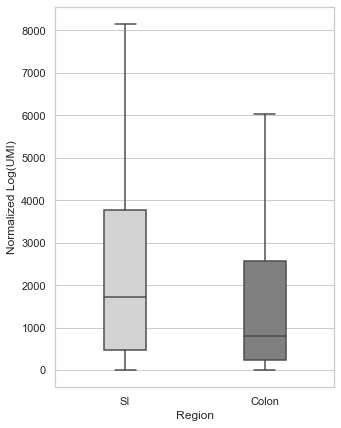

In [59]:
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sns.set(rc={'figure.figsize':(5,7)})
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_style("whitegrid")

batdf =bat.to_df()
small_umi = pd.DataFrame(batdf[[i for i in small_genes.head(100).index]].sum(),columns=['UMI'])
small_umi['Region'] = 'SI'
colon_umi = pd.DataFrame(batdf[[i for i in colon_genes.head(100).index]].sum(),columns=['UMI'])
colon_umi['Region'] = 'Colon'

gut_umi = pd.concat([small_umi,colon_umi])

my_pal = {"SI": "#D3D3D3", "Colon":"#808080"}
boxplots = sns.boxplot(data=gut_umi, x="Region", y="UMI", order=["SI", "Colon"],showfliers = False,palette=my_pal,width=0.3, ).set(title="",ylabel='Normalized Log(UMI)')

plt.savefig("SI_colon_boxplot.pdf",bbox_inches='tight', transparent=True, format="pdf")


In [54]:
colonlist = list(gut_umi[gut_umi.Region=='Colon'].UMI.values)
smalllist = list(gut_umi[gut_umi.Region=='SI'].UMI.values)

In [55]:
from scipy.stats import mannwhitneyu
d={}
d['Colon'] = colonlist
d['SI'] = smalllist
statistic, pvalue1 = mannwhitneyu(d['Colon'], d['SI'], alternative="less")

In [56]:
statistic, pvalue1

(4225.0, 0.029218493369651474)